# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.16 which is incompatible.


The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [2]:
from unityagents import UnityEnvironment
import numpy as np

# select this option to load version 1 (with a single agent) of the environment
#env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')
# select this option to load version 2 (with 20 agents) of the environment
env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726624e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.2109999952837825


When finished, you can close the environment.

In [6]:
#env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [6]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import copy
import random
from collections import namedtuple, deque
from matplotlib import pyplot as plt

In [7]:
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    def __init__(self, state_size, action_size, hidden_size = 256, hidden_size1 = 128):
        super(Actor,self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size,hidden_size1)
        self.fc3 = nn.Linear(hidden_size1,action_size)
        self.reset_parameters()
    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return F.tanh(self.fc3(x))

class Critic(nn.Module):
    def __init__(self, state_size, action_size, hidden_size_s = 256, hidden_size = 128):
        super(Critic, self).__init__()
        self.fs = nn.Linear(state_size,hidden_size_s)
        self.fc1 = nn.Linear(hidden_size_s+action_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)
        self.reset_parameters()
    def reset_parameters(self):
        self.fs.weight.data.uniform_(*hidden_init(self.fs))
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(-3e-3, 3e-3)   
    def forward(self, state, action):
        xs = F.leaky_relu(self.fs(state))
        x = torch.cat((xs, action), dim = 1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)
class OUNoise:
    def __init__(self, size, mu=0., theta=0.2, sigma=0.15):
        self.mu = mu*np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.reset()
    def reset(self):
        self.state = copy.copy(self.mu)
    def sample(self):
        x = self.state
        dx = self.theta*(self.mu - x) + self.sigma*np.array([random.random() for i in range(len(x))])
        self.state = x+dx
        return self.state

class ReplayBuffer:
    def __init__(self, action_size, buffer_size, batch_size):
        self.action_size = action_size
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.memory = deque(maxlen = buffer_size)
        self.experience = namedtuple('Experience',field_names=['state', 'action', 'reward', 'next_state', 'done'])
    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    def sample(self):
        experience = random.sample(self.memory, k=self.batch_size)
        states = torch.from_numpy(np.vstack([e.state for e in experience if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experience if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experience if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experience if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experience if e is not None]).astype(np.uint8)).float().to(device)
        return (states, actions, rewards, next_states, dones)
    def __len__(self):
        return len(self.memory)

In [18]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
class Agent():
    def __init__(self, state_size, action_size):
        self.state_size= state_size
        self.action_size = action_size
        self.actor = Actor(state_size, action_size).to(device)
        self.actor_target = Actor(state_size, action_size).to(device)
        self.actor_target.eval()
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.actor_optim = optim.Adam(self.actor.parameters(), lr = 2e-4)
        self.critic = Critic(state_size, action_size).to(device)
        self.critic_target = Critic(state_size, action_size).to(device)
        self.critic_target.eval()
        self.critic_target.load_state_dict(self.critic.state_dict())
        self.critic_optim = optim.Adam(self.critic.parameters(), lr = 5e-4)
        self.memory = ReplayBuffer(action_size, buffer_size, batch_size)
        self.noise = OUNoise(action_size)
        
    def act(self, state, add_noise=True):
        x = torch.from_numpy(state).float().to(device)
        self.actor.eval()
        with torch.no_grad():
            action = self.actor(x).cpu().data.numpy()
        if add_noise:
            action+=self.noise.sample()
        return np.clip(action,-1,1)
       
    def step(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)
    
    def learn(self, GAMMA = 0.99):
        if len(self.memory)>batch_size:
            experience = self.memory.sample()
            states, actions, rewards, next_states, dones = experience
            next_actions = self.actor_target(next_states)
            Q_next = self.critic_target(next_states,next_actions)
            Q_target = rewards+(GAMMA*Q_next*(1-dones))
            Q_expected = self.critic(states,actions)

            critic_loss = F.mse_loss(Q_expected, Q_target)
            self.critic_optim.zero_grad()
            critic_loss.backward()
            self.critic_optim.step()

            pred_actions = self.actor(states)
            pred_Q = self.critic(states, pred_actions)
            actor_loss= -pred_Q.mean()
            self.actor_optim.zero_grad()
            actor_loss.backward()
            self.actor_optim.step()
            self.soft_update()
    
    def soft_update(self, tau = 0.001):
        for local_param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
            with torch.no_grad():
                target_param.data.copy_(tau*local_param+(1-tau)*target_param)
            
        for local_param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
            with torch.no_grad():
                target_param.data.copy_(tau*local_param+(1-tau)*target_param)
            
    def reset(self):
        self.noise.reset()
        

In [19]:
buffer_size = 1000000
batch_size = 64
agent = Agent(state_size, action_size)

Episode:205 Average score (100 episodes): 22.649184493751264
Episode:210 Average score (100 episodes): 23.89636446587462
Episode:215 Average score (100 episodes): 25.10909943876788
Episode:220 Average score (100 episodes): 26.21470941405557
Episode:225 Average score (100 episodes): 27.428564386923796
Episode:230 Average score (100 episodes): 28.3559193661958
Episode:235 Average score (100 episodes): 29.390684343066997
Environment solved in 238 episodes
Environment solved in 239 episodes
Episode:240 Average score (100 episodes): 30.39607432059478
Environment solved in 240 episodes
Environment solved in 241 episodes
Environment solved in 242 episodes
Environment solved in 243 episodes
Environment solved in 244 episodes
Episode:245 Average score (100 episodes): 31.36854429885838
Environment solved in 245 episodes
Environment solved in 246 episodes
Environment solved in 247 episodes
Environment solved in 248 episodes
Environment solved in 249 episodes
Episode:250 Average score (100 episode

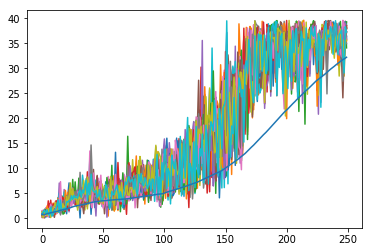

In [23]:
train_every = 20
train_times = 5
scores_record = []
scores_record_100 = []
scores_deque = deque(maxlen=100)
def train(epochs = 250):
    for i_episode in range(epochs):
        env_info = env.reset(train_mode=True)[brain_name]
        agent.reset()
        states = env_info.vector_observations
        scores = np.zeros(num_agents)
        while True:
            actions = np.vstack([agent.act(states[i,:]) for i in range(num_agents)])
            #actions = agent.act(states)
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            scores+=rewards
            for i in range(num_agents):
                agent.step(states[i,:],actions[i,:],rewards[i],next_states[i,:], dones[i])
            agent.learn()
            states = next_states
            if np.any(dones):                                  
                break
        scores_record.append(scores)
        scores_deque.append(scores)
        scores_record_100.append(np.mean(scores_deque))
        if (i_episode+1)%5==0:
            print('Episode:{} Average score (100 episodes): {}'.format(i_episode+1,np.mean(scores_deque)))
        if np.mean(scores_deque)>30:
            print('Environment solved in {} episodes'.format(i_episode+1))
        
train()
plt.plot(scores_record)
plt.plot(scores_record_100)

In [36]:
torch.save(agent.actor.state_dict(), 'checkpoint_actor.pth')
torch.save(agent.critic.state_dict(), 'checkpoint_critic.pth')

torch.save(agent.actor.to('cpu').state_dict(), 'checkpoint_actor_cpu.pth')
torch.save(agent.critic.to('cpu').state_dict(), 'checkpoint_critic_cpu.pth')

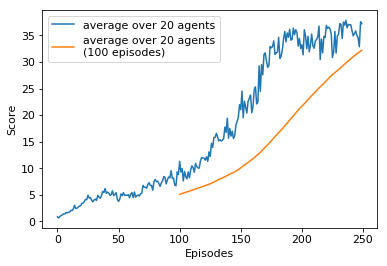

In [34]:
fig, ax = plt.subplots()
score_record_mean = [np.mean(s) for s in scores_record]
ax.plot(score_record_mean, label = 'average over 20 agents')
ax.plot(np.arange(100,len(scores_record_100)),scores_record_100[100:], label = 'average over 20 agents\n(100 episodes)')
ax.set_xlabel('Episodes')
ax.set_ylabel('Score')
fig.patch.set_facecolor('white')
plt.legend() 
plt.rcParams.update({'font.size': 12})